# UC Berkeley | Professional Certificate in Machine Learning and Artificial Intelligence
## Capstone Project 2 (Module 24)

## Final Report

##### Data Selection

Dataset - https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification

Data Definition

- `UID`: unique identifier ranging from 1 to 10000
- `ProductID`: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
- `Air temperature [K]`: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- `Process temperature [K]`: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- `Rotational speed [rpm]`: calculated from powepower of 2860 W, overlaid with a normally distributed noise
- `Torque [Nm]`: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
- `Tool wear [min]`: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

Targets
- `Target` : Failure or Not
- `Failure Type` : Type of Failure


#### Imports and Data Load

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline #as ImbPipeline

from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import (
    accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential


set_config(display="diagram")
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('data/predictive_maintenance.csv', index_col=0)
df.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
UDI,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


#### Initial Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Target                   10000 non-null  int64  
 8   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 781.2+ KB


In [5]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


##### Data Cleanup

In [6]:
df['Product ID'].nunique

<bound method IndexOpsMixin.nunique of UDI
1        M14860
2        L47181
3        L47182
4        L47183
5        L47184
          ...  
9996     M24855
9997     H39410
9998     M24857
9999     H39412
10000    M24859
Name: Product ID, Length: 10000, dtype: object>

Rename Columns

In [7]:
# Going to drop this because it is unique
df.drop(columns='Product ID', axis=1, inplace=True)

df.rename(columns={
    'Type': 'Type',
    'Air temperature [K]': 'AirTemp',    
    'Process temperature [K]': 'ProcTemp',
    'Rotational speed [rpm]': 'RPM',
    'Torque [Nm]': 'Torque',
    'Tool wear [min]': 'ToolWear',
    'Target': 'Failed',
    'Failure Type': 'FailureType'
}, inplace=True)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         10000 non-null  object 
 1   AirTemp      10000 non-null  float64
 2   ProcTemp     10000 non-null  float64
 3   RPM          10000 non-null  int64  
 4   Torque       10000 non-null  float64
 5   ToolWear     10000 non-null  int64  
 6   Failed       10000 non-null  int64  
 7   FailureType  10000 non-null  object 
dtypes: float64(3), int64(3), object(2)
memory usage: 703.1+ KB


In [9]:
df.head()

,Type,AirTemp,ProcTemp,RPM,Torque,ToolWear,Failed,FailureType
UDI,,,,,,,,
1,M,298.1,308.6,1551,42.8,0,0,No Failure
2,L,298.2,308.7,1408,46.3,3,0,No Failure
3,L,298.1,308.5,1498,49.4,5,0,No Failure
4,L,298.2,308.6,1433,39.5,7,0,No Failure
5,L,298.2,308.7,1408,40.0,9,0,No Failure


In [10]:
def plotCount(feature, title, hue, x_rotation):

  plt.figure(figsize=(10,10))

  sns.countplot(data = df, x=feature, hue=hue)
  plt.title(title)
  plt.xticks(rotation=x_rotation)
  plt.savefig(f'images/{title}.png'.replace(' ', '_'))
  plt.show()
  
def plotScatter(x, y, hue, title):
  plt.figure(figsize=(20,12))
  sns.scatterplot(data=df, x=x, y=y, hue=hue)
  plt.title(title)
  plt.savefig(f'images/{title}.png'.replace(' ', '_'))
  plt.show()

##### Create Data Visualization Plots

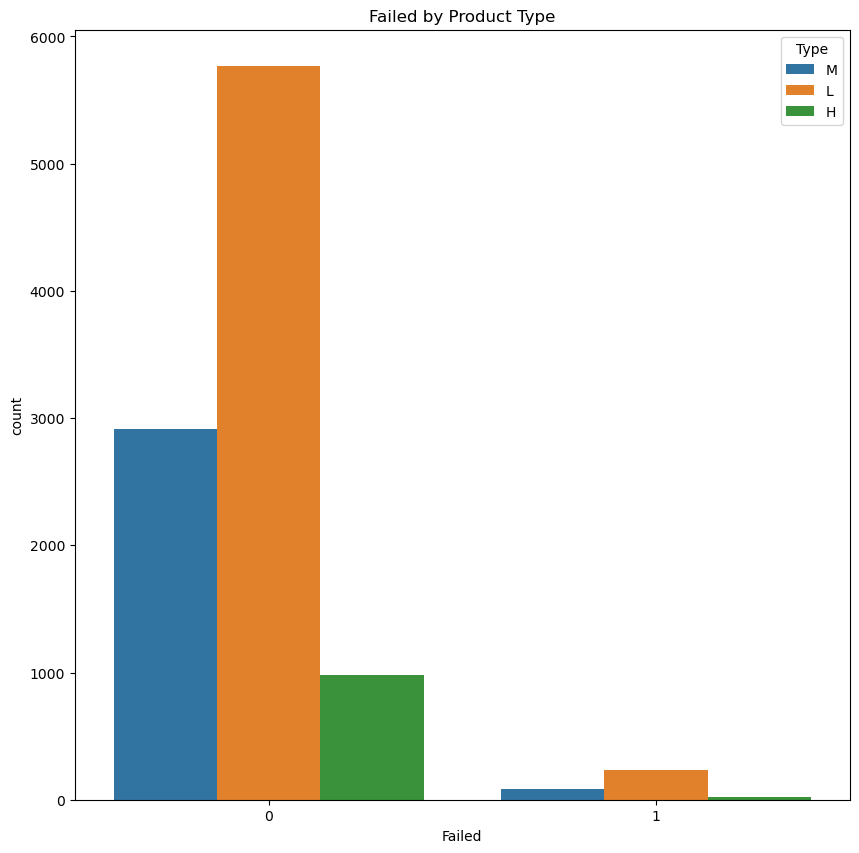

In [11]:
plotCount('Failed', 'Failed by Product Type', 'Type', None)

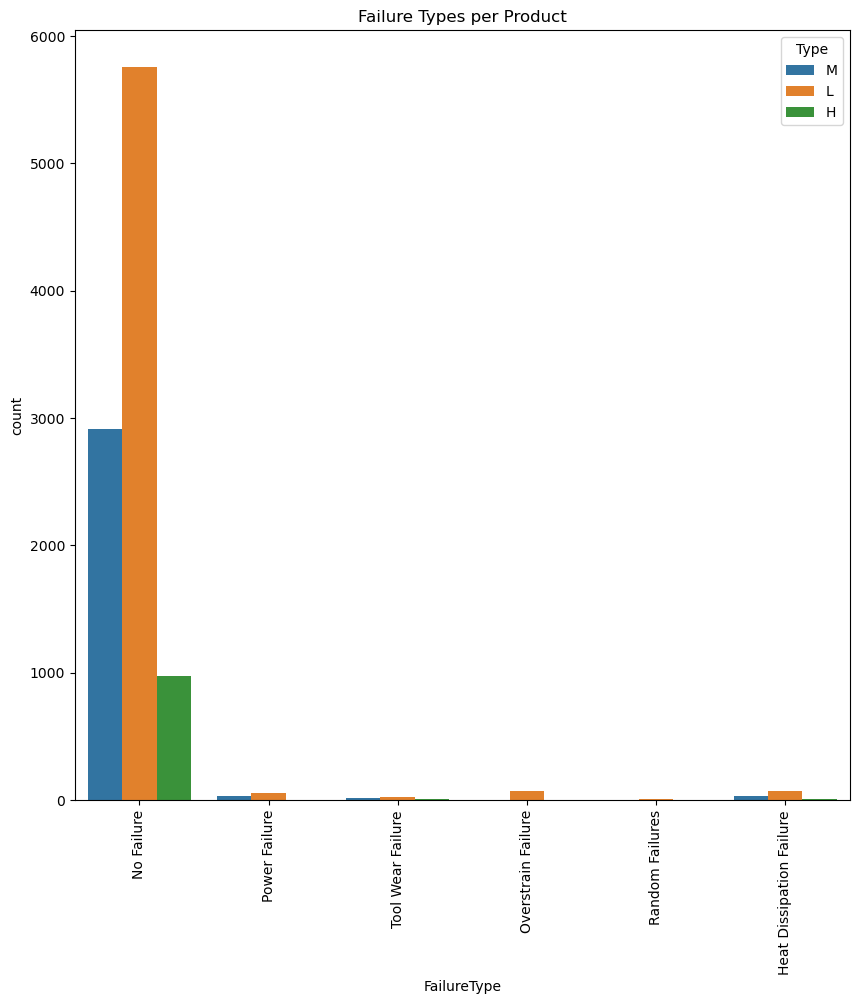

In [12]:
plotCount('FailureType', 'Failure Types per Product', 'Type', 90)

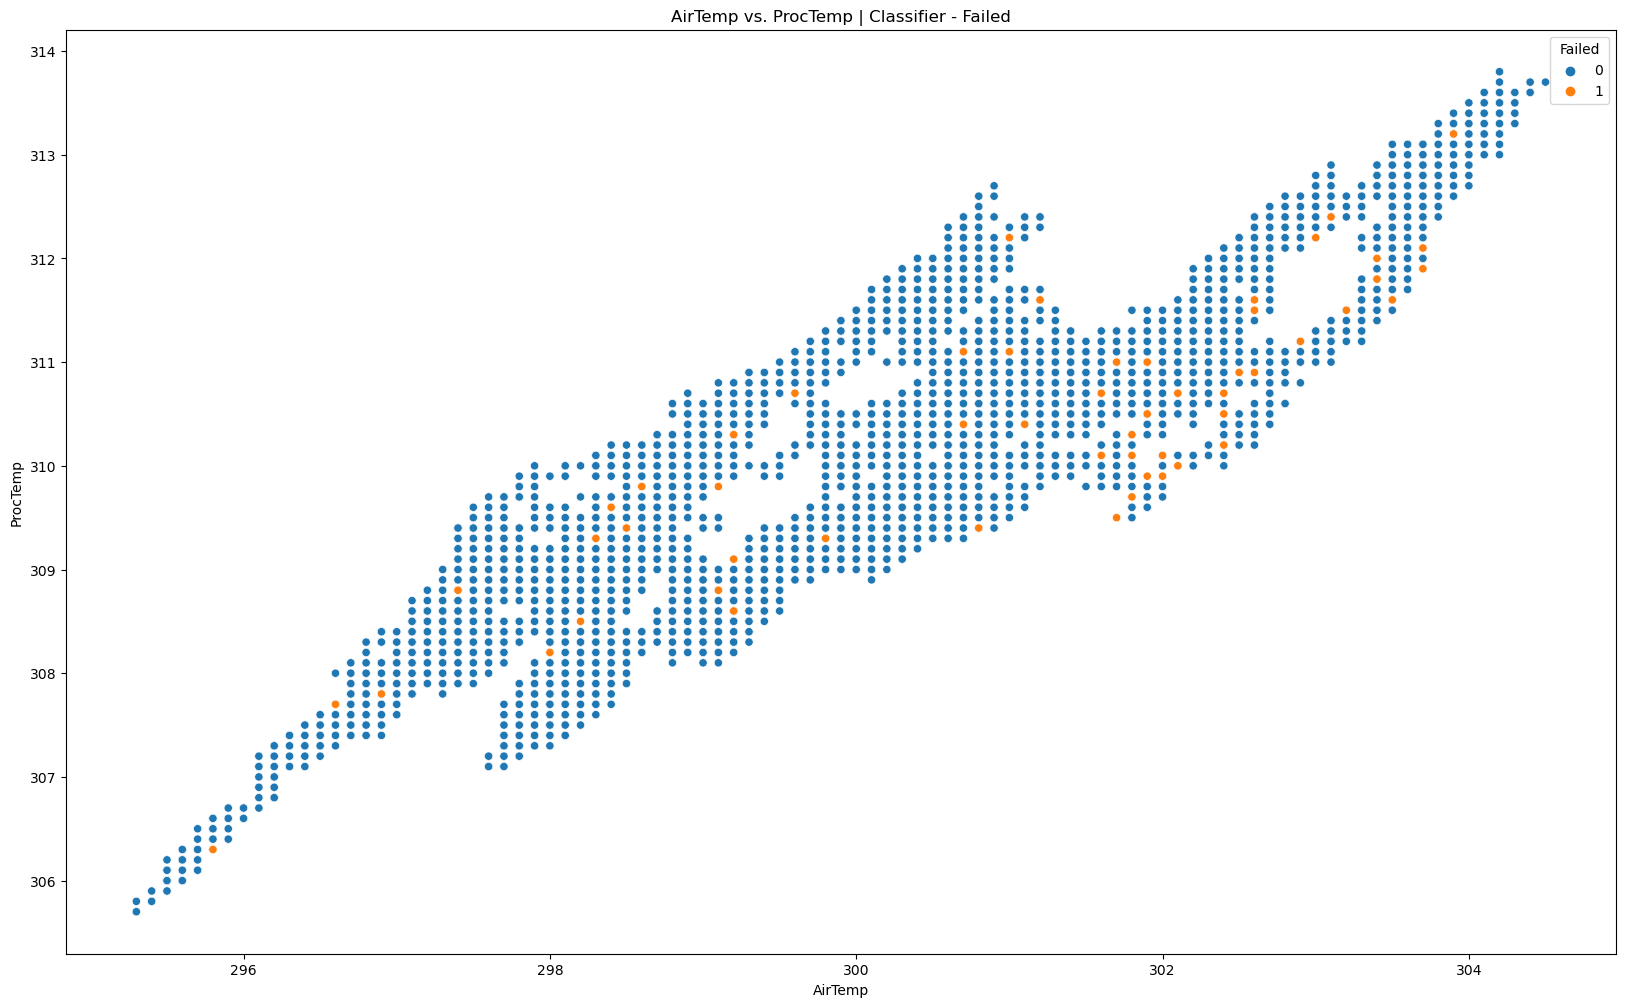

In [13]:
plotScatter(x='AirTemp', y='ProcTemp', hue='Failed', title='AirTemp vs. ProcTemp | Classifier - Failed')

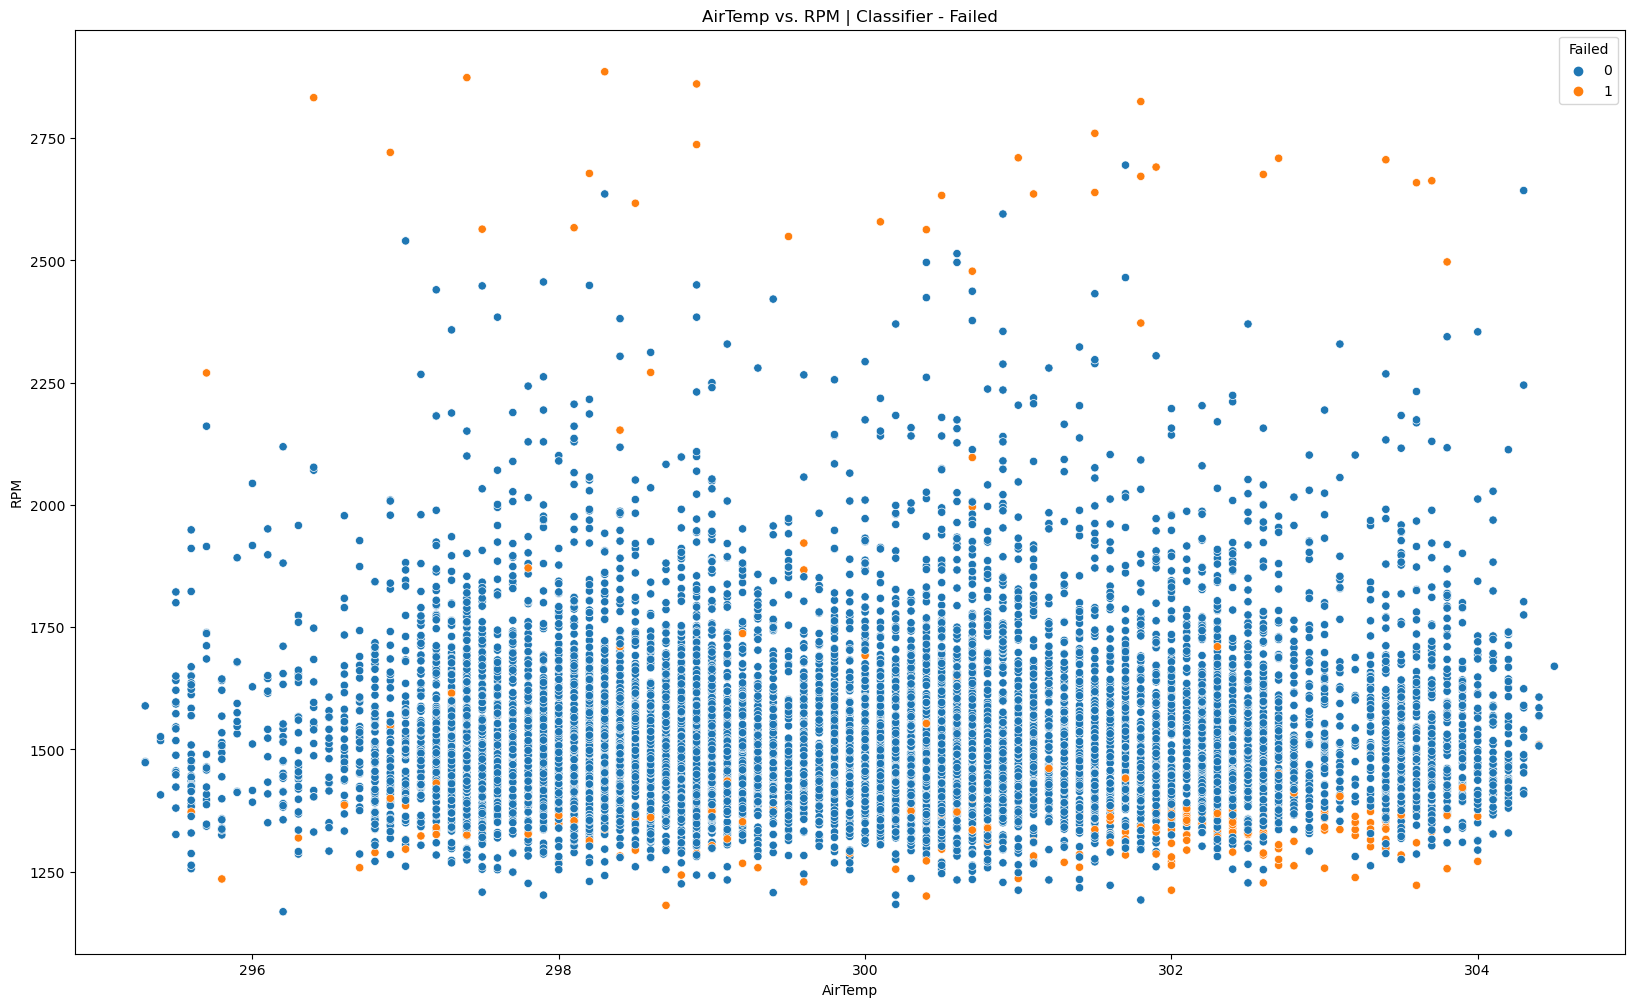

In [14]:
plotScatter(x='AirTemp', y='RPM', hue='Failed', title='AirTemp vs. RPM | Classifier - Failed')

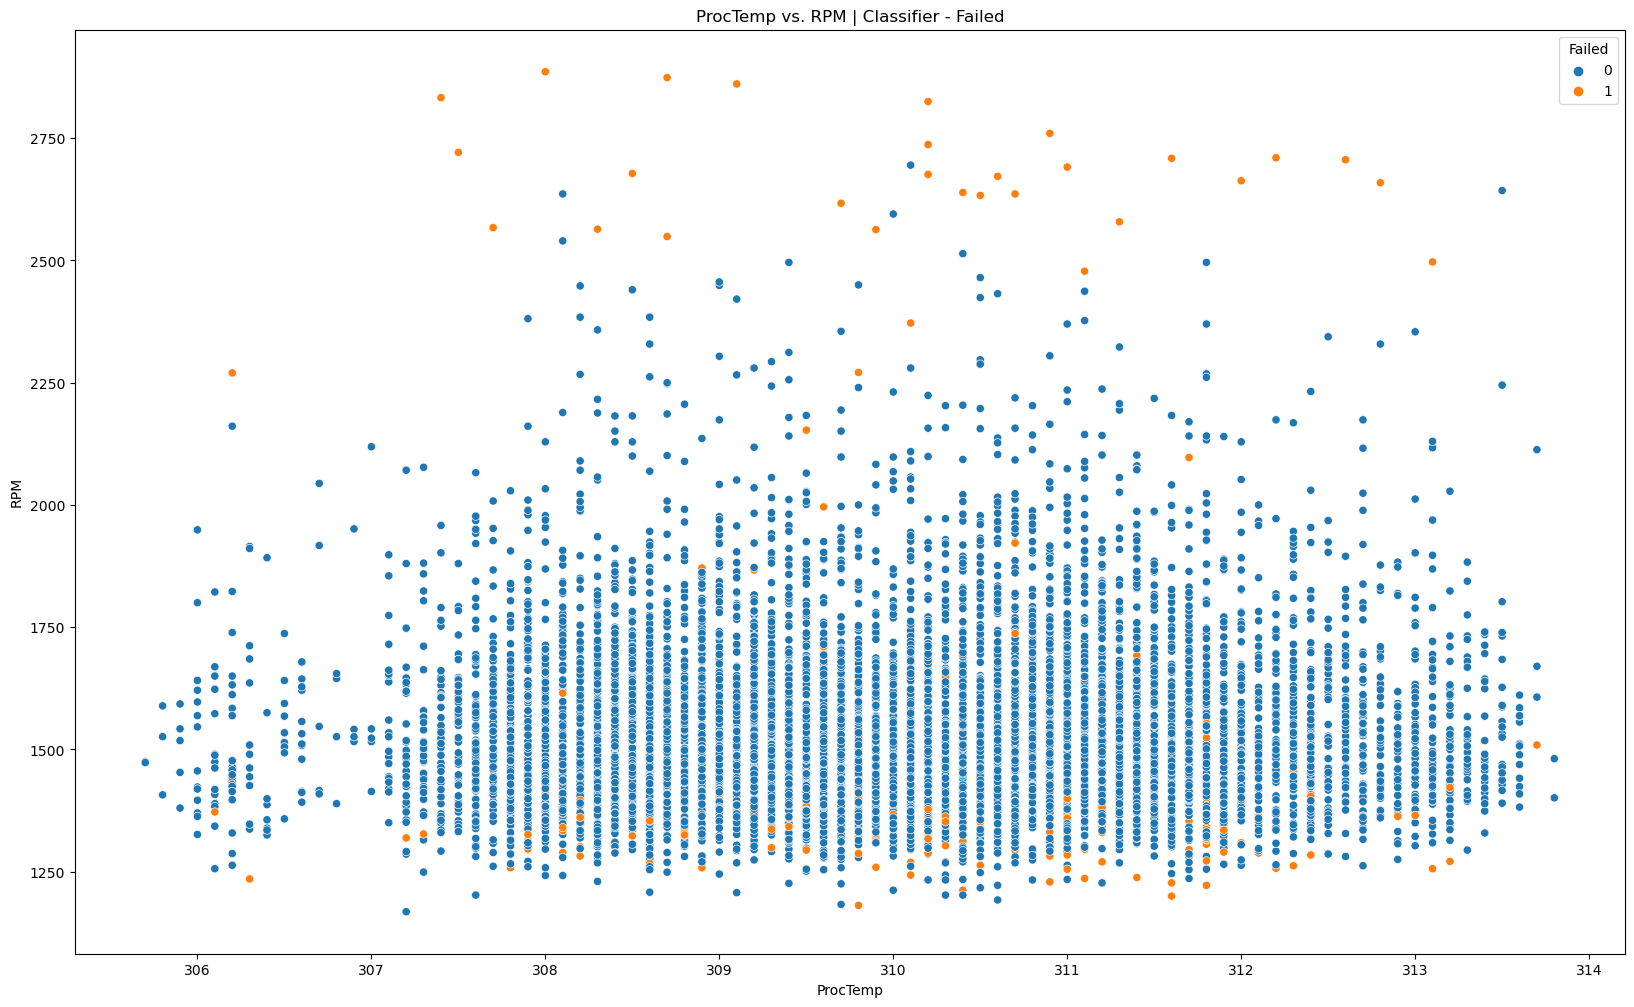

In [15]:
plotScatter(x='ProcTemp', y='RPM', hue='Failed', title='ProcTemp vs. RPM | Classifier - Failed')

Feature Correlations

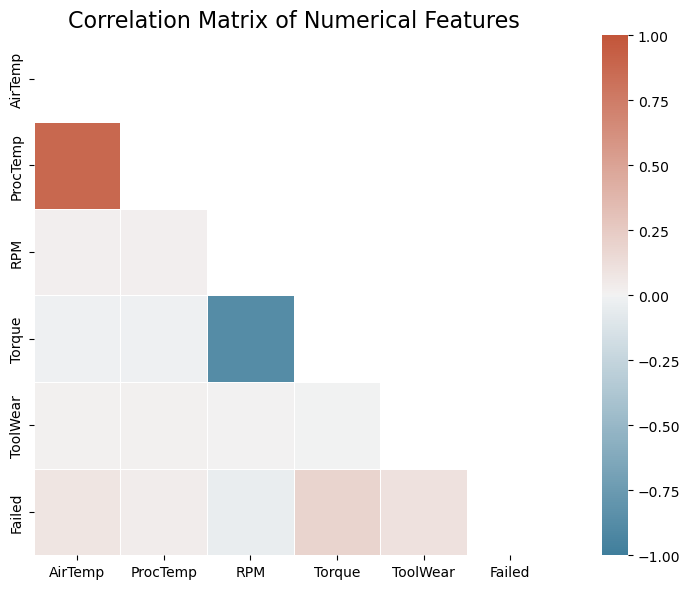

In [16]:
plt.figure(figsize=(10, 6))

numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=False)

plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.savefig('images/correlation_matrix.png', dpi=300)
plt.show()

In [17]:
corr

,AirTemp,ProcTemp,RPM,Torque,ToolWear,Failed
AirTemp,1.000000,0.876107,0.022670,-0.013778,0.013853,0.082556
ProcTemp,0.876107,1.000000,0.019277,-0.014061,0.013488,0.035946
RPM,0.022670,0.019277,1.000000,-0.875027,0.000223,-0.044188
Torque,-0.013778,-0.014061,-0.875027,1.000000,-0.003093,0.191321
ToolWear,0.013853,0.013488,0.000223,-0.003093,1.000000,0.105448
Failed,0.082556,0.035946,-0.044188,0.191321,0.105448,1.000000


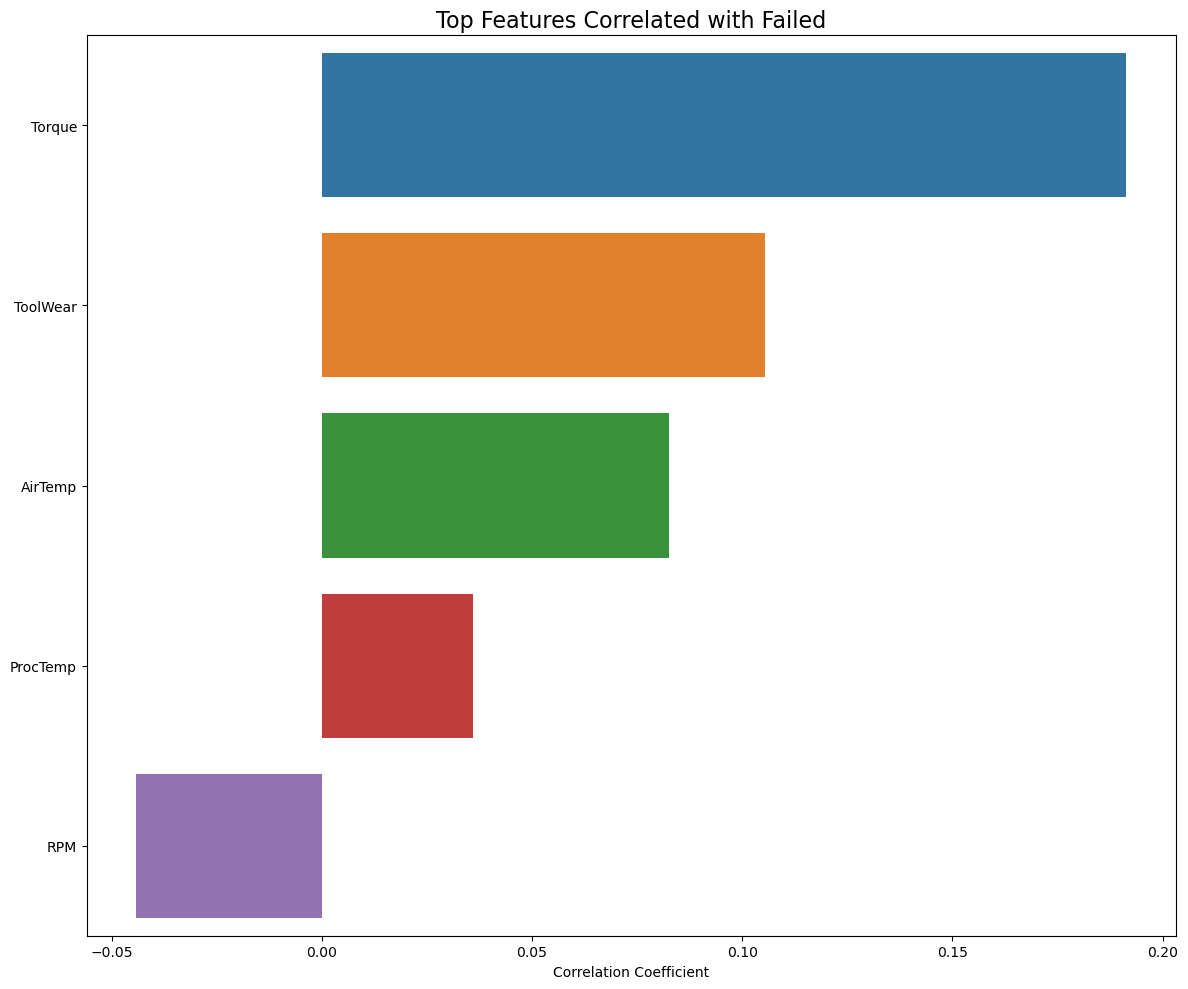

In [18]:
plt.figure(figsize=(12, 10))

corr_with_target = corr['Failed'].sort_values(ascending=False)
top_features = corr_with_target[1:6]  

sns.barplot(x=top_features.values, y=top_features.index)

plt.title('Top Features Correlated with Failed', fontsize=16)
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.savefig('images/top_correlations.png', dpi=300)
plt.show()

##### Initial Analysis

Based on the initial analysis, data shows the correlation table shows a strong positive correlation between air temperature and process temperature (r = 0.88), indicating they increase together. 

Rotational speed (RPM) and torque have a strong negative correlation (r = -0.88), suggesting that higher speed is associated with lower torque. Failure has the highest positive correlation with torque (r = 0.19) and tool wear (r = 0.11), though these correlations are still relatively weak. 

Overall, most variables show low direct correlation with failure, implying other factors or combinations may be at play.

#### Create Train/Test Split Datasets

In [19]:
X = df.drop(columns=['Failed'], axis=1)
y = df['Failed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.head()

,Type,AirTemp,ProcTemp,RPM,Torque,ToolWear,FailureType
UDI,,,,,,,
9255,L,298.3,309.1,1616,31.1,195,No Failure
1562,L,298.2,308.4,1388,53.8,137,No Failure
1671,L,298.2,307.8,1528,31.1,194,No Failure
6088,M,300.9,310.8,1599,33.0,7,No Failure
6670,L,301.4,310.5,1571,33.9,208,No Failure


#### Create Intial Basic Models

Identify Numerical and Categorical Features

In [21]:
categorical_columns = ['Type']
numerical_columns = ['AirTemp', 'ProcTemp', 'RPM', 'Torque', 'ToolWear']

Create Transformer

In [22]:
transformer = make_column_transformer(
    (StandardScaler(), numerical_columns),
    (OneHotEncoder(drop='if_binary', sparse_output=False), categorical_columns)
)

##### Imbalanced Dataset
Since we have an imbalanced dataset, I'm using SMOTE to make it balanced.
This will help the models improve performance.

##### K-Nearest Neighbor

Create KNN Pipeline

In [23]:
knn_pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('smote', SMOTE(random_state=42)),  
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['AirTemp', 'ProcTemp', 'RPM',
                                                   'Torque', 'ToolWear']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Type'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', KNeighborsClassifier())])

5-fold Cross Validation, Train and Predict

In [24]:
param_grid = {
    'classifier__n_neighbors': list(range(5, 21))  # Test n_neighbors from 5 to 20
}

# Create the GridSearchCV object with 5-fold cross-validation
grid_search_knn = GridSearchCV(knn_pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

y_pred = grid_search_knn.predict(X_test)

print("Best Parameters:", grid_search_knn.best_params_)
print("Best Cross-validation Score:", grid_search_knn.best_score_)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Best Parameters: {'classifier__n_neighbors': 6}
Best Cross-validation Score: 0.9328749999999999

Accuracy: 0.9370

Confusion Matrix:
[[1829  110]
 [  16   45]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1939
           1       0.29      0.74      0.42        61

    accuracy                           0.94      2000
   macro avg       0.64      0.84      0.69      2000
weighted avg       0.97      0.94      0.95      2000



In [25]:
def plotConfusion_matrix(title, values):
  plt.figure(figsize=(8, 6))
  
  disp = ConfusionMatrixDisplay(
    confusion_matrix=values,
    display_labels=['No Failure', 'Failure']
  )
  
  disp.plot(cmap='Blues', values_format='d')
  plt.title(title)
  plt.savefig(f'images/{title}.png'.replace(' ', '_'))

  plt.show()

<Figure size 800x600 with 0 Axes>

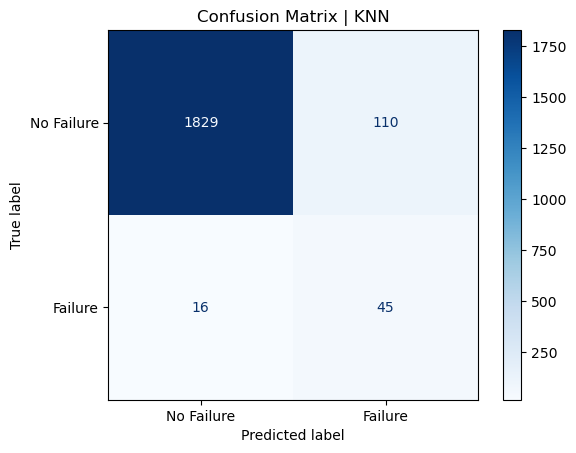

In [26]:
plotConfusion_matrix('Confusion Matrix | KNN', conf_matrix)

##### Decision Trees

Create Decision Trees Pipeline

In [27]:
dt_pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('smote', SMOTE(random_state=42)),  
    ('classifier', DecisionTreeClassifier(max_depth=5))
])

dt_pipeline

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['AirTemp', 'ProcTemp', 'RPM',
                                                   'Torque', 'ToolWear']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Type'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', DecisionTreeClassifier(max_depth=5))])

5-fold Cross Validation, Train and Predict

In [28]:
param_grid_dt = {
    'classifier__max_depth': [3, 5, 7, None],             # Explore different tree depths
    'classifier__min_samples_split': [2, 5, 10],          # Minimum samples to split a node
    'classifier__criterion': ['gini', 'entropy']          # Splitting criterion
}

grid_search_dt = GridSearchCV(dt_pipeline, param_grid=param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

y_pred = grid_search_dt.predict(X_test)

# Evaluate the model
print("Best Parameters:", grid_search_dt.best_params_)
print("Best Cross-validation Score:", grid_search_dt.best_score_)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix_dt = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\Decision Tree Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_dt)
print("\nClassification Report:")
print(class_report)

Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_split': 5}
Best Cross-validation Score: 0.963125
\Decision Tree Accuracy: 0.9615

Confusion Matrix:
[[1879   60]
 [  17   44]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1939
           1       0.42      0.72      0.53        61

    accuracy                           0.96      2000
   macro avg       0.71      0.85      0.76      2000
weighted avg       0.97      0.96      0.97      2000



<Figure size 800x600 with 0 Axes>

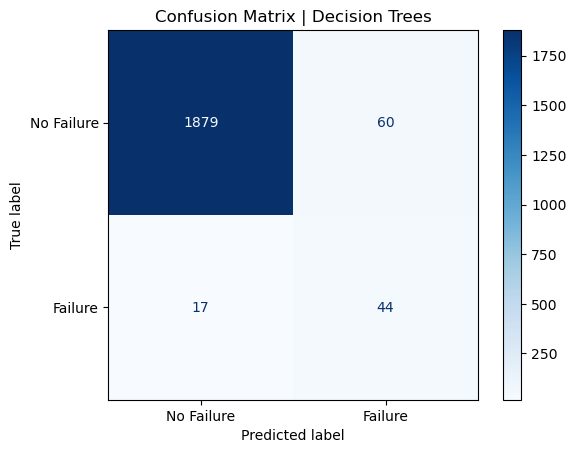

In [29]:
plotConfusion_matrix('Confusion Matrix | Decision Trees', conf_matrix_dt)

##### Logistic Regression

Create Logistics Regression Pipeline

In [30]:
lr_pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('smote', SMOTE(random_state=42)),  
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

lr_pipeline

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['AirTemp', 'ProcTemp', 'RPM',
                                                   'Torque', 'ToolWear']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Type'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

5-fold Cross Validation, Train and Predict

In [31]:
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['saga']  # 'saga' supports both l1 and l2 penalties
}

grid_search_lr = GridSearchCV(lr_pipeline, param_grid=param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

grid_search_lr.predict(X_test)

# Evaluate the model
print("Best Parameters:", grid_search_lr.best_params_)
print("Best Cross-validation Score:", grid_search_lr.best_score_)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix_lg = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\nLogistic Regression Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_lg)
print("\nClassification Report:")
print(class_report)

Best Parameters: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best Cross-validation Score: 0.82575

Logistic Regression Accuracy: 0.9615

Confusion Matrix:
[[1879   60]
 [  17   44]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1939
           1       0.42      0.72      0.53        61

    accuracy                           0.96      2000
   macro avg       0.71      0.85      0.76      2000
weighted avg       0.97      0.96      0.97      2000



<Figure size 800x600 with 0 Axes>

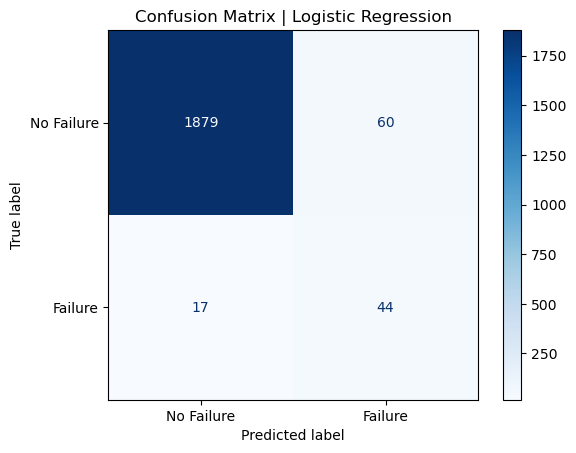

In [32]:
plotConfusion_matrix('Confusion Matrix | Logistic Regression', conf_matrix_lg)

##### SVM (Support Vector Machine)

Create SVM Pipeline

In [33]:
svm_pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('smote', SMOTE(random_state=42)),  
    ('classifier', SVC(probability=True, random_state=42))
])

svm_pipeline

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['AirTemp', 'ProcTemp', 'RPM',
                                                   'Torque', 'ToolWear']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Type'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', SVC(probability=True, random_state=42))])

5-fold Cross Validation, Train and Predict

In [34]:
# Start the timer
start_time = time.time()

param_grid_svm = {
    'classifier__C': [.1, 10, 100],
    'classifier__kernel': ['linear', 'rbf']
}

grid_search_svm = GridSearchCV(svm_pipeline, param_grid=param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)

# Calculate training time
training_time = time.time() - start_time
print(f"SVM model training completed in {training_time:.2f} seconds")

y_pred = grid_search_svm.predict(X_test)

# Evaluate the model
print("Best Parameters:", grid_search_svm.best_params_)
print("Best Cross-validation Score:", grid_search_svm.best_score_)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix_svm = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\nSVM (Linear Kernel) Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_svm)
print("\nClassification Report:")
print(class_report)

SVM model training completed in 431.77 seconds
Best Parameters: {'classifier__C': 100, 'classifier__kernel': 'rbf'}
Best Cross-validation Score: 0.9556250000000001

SVM (Linear Kernel) Accuracy: 0.9510

Confusion Matrix:
[[1855   84]
 [  14   47]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1939
           1       0.36      0.77      0.49        61

    accuracy                           0.95      2000
   macro avg       0.68      0.86      0.73      2000
weighted avg       0.97      0.95      0.96      2000



<Figure size 800x600 with 0 Axes>

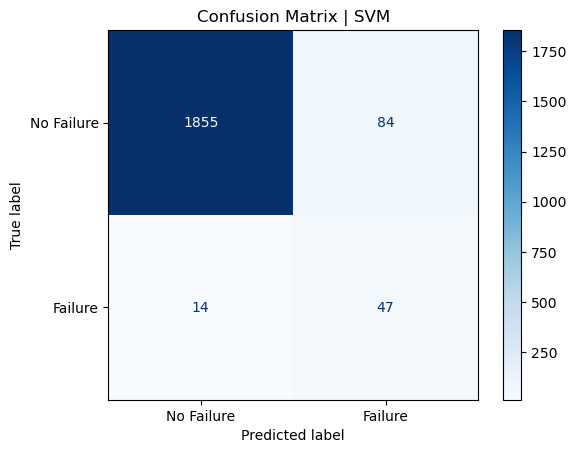

In [35]:
plotConfusion_matrix('Confusion Matrix | SVM', conf_matrix_svm)

## Results

#### Accuracy & Confusion Matrix

| **Model**                         | **Accuracy** | **Confusion Matrix**           |
|:----------------------------------|:------------:|:------------------------------:|
| **K-Nearest Neighbor (K=5)**      | 0.9370       | [[1829, 110], [16, 45]]        |
| **Decision Tree**                 | 0.9628       | [[1881, 58], [17, 44]]         |
| **Logistic Regression**           | 0.9510       | [[1856, 83], [15, 46]]         |
| **SVM (Linear Kernel)**           | 0.9510       | [[1855, 84], [14, 47]]         |



## Deep Learning

Create Model

In [40]:
pipeline_dl = Pipeline(steps=[
    ('transformer', transformer),
    ('smote', SMOTE(random_state=42))
])

Apply re-sampling because we have imbalanced data:

In [43]:
X_train_resampled, y_train_resampled = pipeline_dl.fit_resample(X_train, y_train)

X_test_transformed = transformer.transform(X_test)

In [44]:
# Create inital model with 1 hidden layer 
# I'm using sigmoid as my top layer because of the binary claasifiction of the target: 0 or 1
model = Sequential([
    Dense(100, activation = 'relu'),
    Dense(100, activation = 'relu'),
    Dense(100, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

# bce is for BinaryCrossEntropy - best for binary classification
# RMSprop is my arbitrary choice for optimization based on the past lectures
model.compile(
  loss = 'bce', 
  optimizer = 'rmsprop',
  metrics = ['accuracy']
)

# Train the model
history = model.fit(
  X_train_resampled, 
  y_train_resampled, 
  validation_data = (X_test_transformed, y_test),
  epochs = 40, 
  batch_size = 10,
  verbose = 0
)

In [45]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 100)            │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,404 (165.64 KB)

 Trainable params: 21,201 (82.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,203 (82.83 KB)

In [46]:
print('Training Accuracy: ',  history.history['accuracy'][-1])
print('Testing Accuracy: ', history.history['val_accuracy'][-1])

Training Accuracy:  0.9762367010116577
Testing Accuracy:  0.9570000171661377


#### Model Performance Metrics

Training Accuracy:  `0.9762367010116577`

Testing Accuracy:  `0.9570000171661377`

#### Prediction and Results

In [47]:
y_train_pred = (model.predict(X_train_resampled) >= 0.5).astype(int)
y_test_pred = (model.predict(X_test_transformed) >= 0.5).astype(int)

483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


In [48]:
conf_matrix_dl = conf_matrix = confusion_matrix(y_test, y_test_pred)

<Figure size 800x600 with 0 Axes>

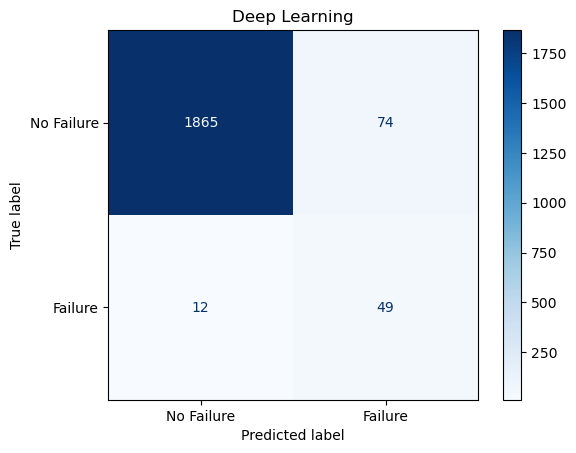

In [49]:
plotConfusion_matrix('Deep Learning', conf_matrix_dl)

# Conclusion

Deep learning using TensorFlow outperformed traditional models by demonstrating a robust balance between high overall accuracy and effective identification of equipment failures. 

Its training accuracy of 97.62% and testing accuracy of 95.70% indicate that it generalizes well to unseen data. The confusion matrix—showing only 12 false negatives and 74 false positives—highlights its strong ability to correctly detect failures while minimizing missed alerts. Fewer false negatives are critical for proactive maintenance, ensuring that potential issues are caught early before leading to costly downtime. 

This predictive strength allows maintenance to be scheduled optimally, significantly reducing unexpected equipment failures and operational interruptions. 

Overall, deep learning is the best model for predicting and scheduling equipment maintenance, ultimately saving the manufacturing company money through improved efficiency and reliability.